In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [0]:
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

We do have several columns with missing values, however, the first thing to take care of is column headers. Several of them have leading (or possibly trailing) spaces, as well as some columns capitalizing words while others do not. We'll start by removing trailing/leading spaces, then converting to lower case (except for acronyms) and replacing all interior spaces with underscores.

In [0]:
for col in lifeexpectancy_df.columns.tolist():
  new_col = col.strip().replace('  ', ' ').replace(' ', '_').replace('-', '_')  # eliminate white space
  if not new_col.isupper(): # preserve acronyms
    new_col = new_col.lower()
  new_col = new_col.replace('1_19', '10_19') # fixing error in thinness 10-19 column header
  lifeexpectancy_df.rename(columns={col: new_col}, inplace=True)

In [0]:
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
BMI                                2904 non-null float64
under_five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-null

Column names look good. Next I am going to change several entries in the country field. The reason for this is that population and GDP data contain a lot of incorrect values due to some data corruption. Changing the country names so they match corresponding data sets from World Bank will make overwriting incorrect values much easier.

In [0]:
old_country_names = ['Bahamas', 'Bolivia (Plurinational State of)', 'Congo', 
                     'Czechia', "Côte d'Ivoire", "Democratic People's Republic of Korea",
                     'Democratic Republic of the Congo', 'Egypt', 'Gambia',
                     'Iran (Islamic Republic of)', 'Kyrgyzstan',
                     "Lao People's Democratic Republic", 'Micronesia (Federated States of)',
                     'Republic of Korea', 'Republic of Moldova', 'Saint Kitts and Nevis',
                     'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia',
                     'The former Yugoslav republic of Macedonia',
                     'United Kingdom of Great Britain and Northern Ireland',
                     'United Republic of Tanzania', 'United States of America',
                     'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Yemen']

new_country_names = ['Bahamas, The', 'Bolivia', 'Congo, Rep.', 'Czech Republic',
                     "Cote d'Ivoire", "Korea, Dem. People's Rep.",
                     'Congo, Dem. Rep.', 'Egypt, Arab Rep.', 'Gambia, The',
                     'Iran, Islamic Rep.', 'Kyrgyz Republic', 'Lao PDR',
                     'Micronesia, Fed. Sts.', 'Korea, Rep.', 'Moldova',
                     'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines',
                     'Slovak Republic', 'Macedonia, FYR', 'United Kingdom',
                     'Tanzania', 'United States', 'Venezuela, RB', 'Vietnam',
                     'Yemen, Rep.']

In [0]:
# fix country names to match those on World Bank
for i, name in enumerate(old_country_names):
  new_name = new_country_names[i]
  lifeexpectancy_df.loc[lifeexpectancy_df['country'] == name, 'country'] = new_name

Since our data is time series, we'll begin by filling missing values using interpolation within each country, after sorting by year.

In [0]:
# Sort by country and then by year before interpolation
lifeexpectancy_df = lifeexpectancy_df.sort_values(by=['country', 'year'])

# List of countries
countries = lifeexpectancy_df['country'].unique().tolist()

# Interpolate within each country
for country in countries:
  lifeexpectancy_df.loc[lifeexpectancy_df['country'] == country] = lifeexpectancy_df.loc[lifeexpectancy_df['country'] == country].interpolate(limit_direction='both')

In [0]:
print('Percentage of Missing Values by Column')
lifeexpectancy_df.isnull().sum()*100/lifeexpectancy_df.isnull().count()

Percentage of Missing Values by Column


country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.340368
infant_deaths                       0.000000
alcohol                             0.578625
percentage_expenditure              0.000000
hepatitis_b                         4.901293
measles                             0.000000
BMI                                 1.157250
under_five_deaths                   0.000000
polio                               0.000000
total_expenditure                   1.089176
diphtheria                          0.000000
HIV/AIDS                            0.000000
GDP                                13.784888
population                         22.055820
thinness_10_19_years                1.157250
thinness_5_9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [0]:
lifeexpectancy_df.loc[lifeexpectancy_df['country'] == 'Afghanistan']

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling
15,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.424960,62.0,6532,12.2,122,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
14,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.574728,63.0,8762,12.6,122,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
13,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.887351,64.0,2486,13.0,122,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
12,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.296066,67.0,466,13.8,120,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8
10,Afghanistan,2005,Developing,57.3,291.0,85,0.02,1.388648,66.0,1296,14.2,118,58.0,8.70,58.0,0.1,25.294130,257798.0,19.3,19.5,0.396,7.9
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,14.7,116,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,15.2,113,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,15.7,110,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,16.2,106,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9


There are a lot of missing population values, and by examining the data for Afghanistan, it's apparent that many of the ones we have are flat out wrong. After a cursory look through some of Afghanistan's statistics, I've conlcuded that somehow, all of the zeroes before the decimal point have been removed (i.e. the population of 293,756 in 2000 is actually supposed to be 20,093,756). Very likely, on inspection, the same thing has happened in every single column with the data type float64.

Plan of action for float64 columns is as follows:
1. Since Population and GDP have large numbers of values missing, and info on these categories is readily available from other datasets, I'll import a new dataset and overwrite the current data with the information from that one.
2. For the other columns, while I'd like to eventually implement a better system, for the time being we'll transform the columns, which should mitigate the problem.

Additionally, the measles data is meaningless. There are more than 500 rows where the number of measles cases per 1000 population is more than 1000. That's more than 15% of the data. Something catastrophic happened here, and I can't find any data online that can either confirm these numbers, or offer an explanation for them. With that being the case, the best move, as near as I can tell, is to just eliminate the column entirely, and not let it corrupt our conclusions moving forward.

In all honesty, this entire data set is pretty dismal. Were I to use this data for my professional work, I would simply gather the data from World Bank and the GHO myself, and recreate all the fields independently followed by data cleaning. Whether done intentionally, so as to create a learning opportunity (challenge), or simply as a result of being reformatted several times, this data set is almost unusable for any meaningful analysis.

In [0]:
# eliminate measles column
lifeexpectancy_df = lifeexpectancy_df.drop(columns='measles')

In [0]:
# import population data from World Bank
populations_df = pd.read_csv('https://github.com/ADEnnaco/datasets/raw/master/country_population.csv', index_col=0)

In [0]:
countries1 = lifeexpectancy_df['country'].unique().tolist()
countries2 = populations_df.index.tolist()
countries_intersect = set(countries1) & set(countries2)

# overwrite corrupted population values with correct values from World Bank
for country in countries_intersect:
  years = lifeexpectancy_df.loc[lifeexpectancy_df['country'] == country]['year'].unique().tolist()
  for year in years:
    lifeexpectancy_df.loc[(lifeexpectancy_df['country'] == country) & (lifeexpectancy_df['year'] == year), 'population'] = populations_df.loc[country, str(year)]

In [0]:
# import GDP data from World Bank
worldGDP_df = pd.read_csv('https://github.com/ADEnnaco/datasets/raw/master/world_GDP_data.csv', index_col=0)

In [0]:
countries1 = lifeexpectancy_df['country'].unique().tolist()
countries2 = worldGDP_df.index.tolist()
countries_intersect = set(countries1) & set(countries2)

# overwrite corrupted population values with values from World Bank
for country in countries_intersect:
  years = lifeexpectancy_df.loc[lifeexpectancy_df['country'] == country]['year'].unique().tolist()
  for year in years:
    if worldGDP_df.loc[country, str(year)] != '..': # don't want to insert '..' from World Bank data
      lifeexpectancy_df.loc[(lifeexpectancy_df['country'] == country) & (lifeexpectancy_df['year'] == year), 'GDP'] = worldGDP_df.loc[country, str(year)]

# GDP values in World Bank set were strings, so we conver them to float to preserve the datatype
lifeexpectancy_df['GDP'] = lifeexpectancy_df['GDP'].astype(float)

Now that population and GDP values have been filled in with data from World Bank, we'll drop the rows that are still empty in either. This represents less than 2% of our data, at most. Afterwards, the rest of the missing values are replaced using median values for the respective column.

In [0]:
lifeexpectancy_df = lifeexpectancy_df.dropna(subset=['GDP', 'population'])

In [0]:
# columns with missing data
fill_columns = ['life_expectancy', 'adult_mortality', 'alcohol', 'hepatitis_b',
                'BMI', 'total_expenditure', 'thinness_10_19_years', 'thinness_5_9_years',
                'income_composition_of_resources', 'schooling']

In [0]:
# replace missing values with medians
for col in fill_columns:
  lifeexpectancy_df[col] = lifeexpectancy_df[col].fillna(lifeexpectancy_df[col].median())

In [0]:
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2899 entries, 15 to 2922
Data columns (total 21 columns):
country                            2899 non-null object
year                               2899 non-null int64
status                             2899 non-null object
life_expectancy                    2899 non-null float64
adult_mortality                    2899 non-null float64
infant_deaths                      2899 non-null int64
alcohol                            2899 non-null float64
percentage_expenditure             2899 non-null float64
hepatitis_b                        2899 non-null float64
BMI                                2899 non-null float64
under_five_deaths                  2899 non-null int64
polio                              2899 non-null float64
total_expenditure                  2899 non-null float64
diphtheria                         2899 non-null float64
HIV/AIDS                           2899 non-null float64
GDP                                2899 non-n

All missing values have been eliminated. We have 39 fewer rows than we started with, but the vast majority of our data points have been preserved. Next we'll do some exploration to identify outliers and overal data shape, and relationships between variables and the target.

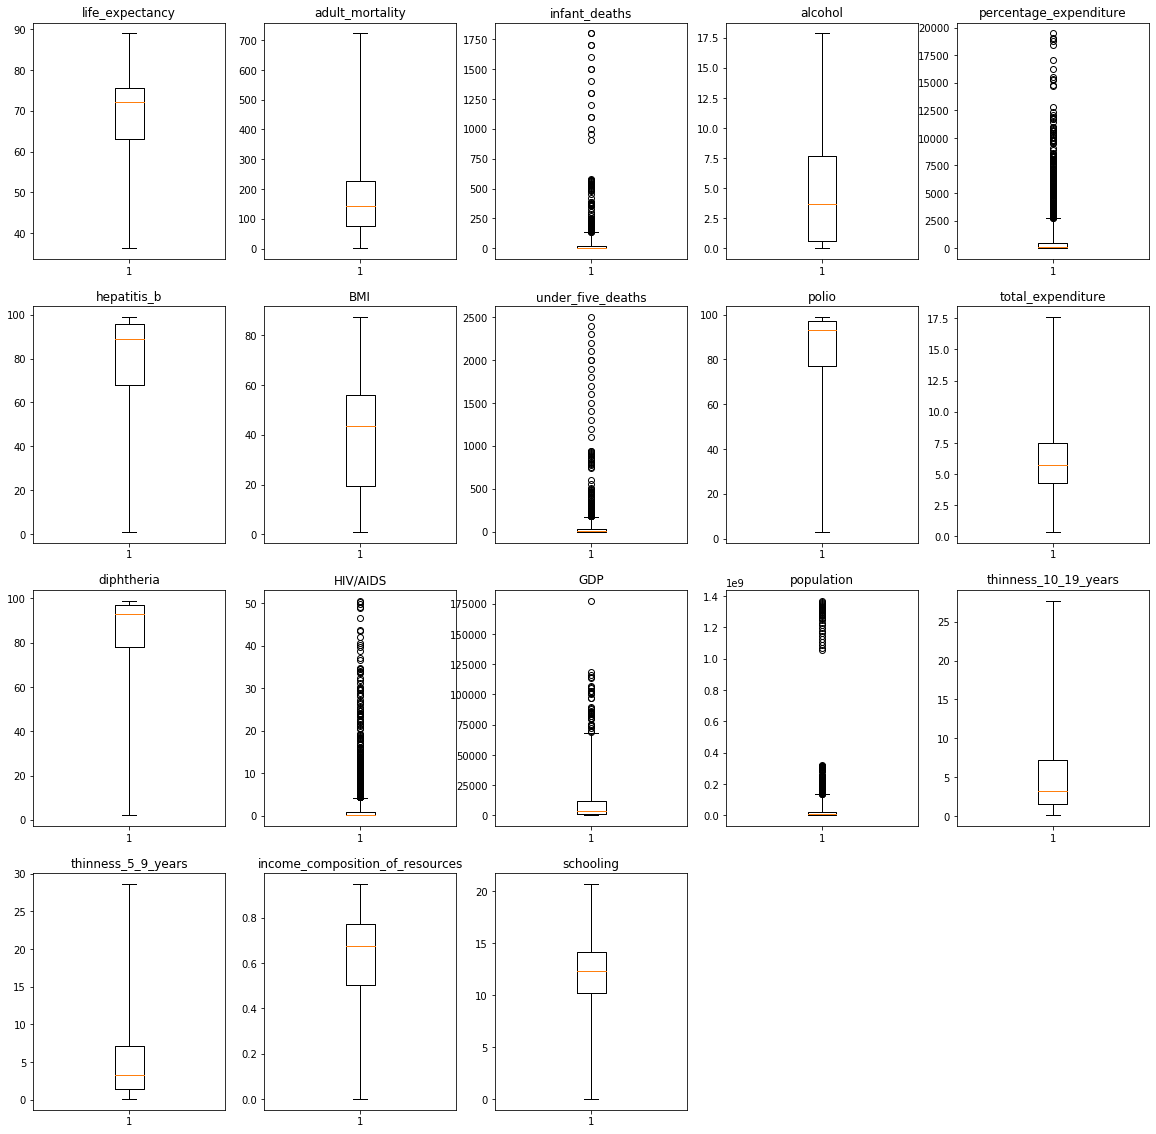

In [0]:
plt.figure(figsize=(20,20))

for i, col in enumerate(lifeexpectancy_df.columns[3:]):
  plt.subplot(4,5,i+1)
  plt.boxplot(lifeexpectancy_df[col], whis=5)
  plt.title(col)

plt.show()

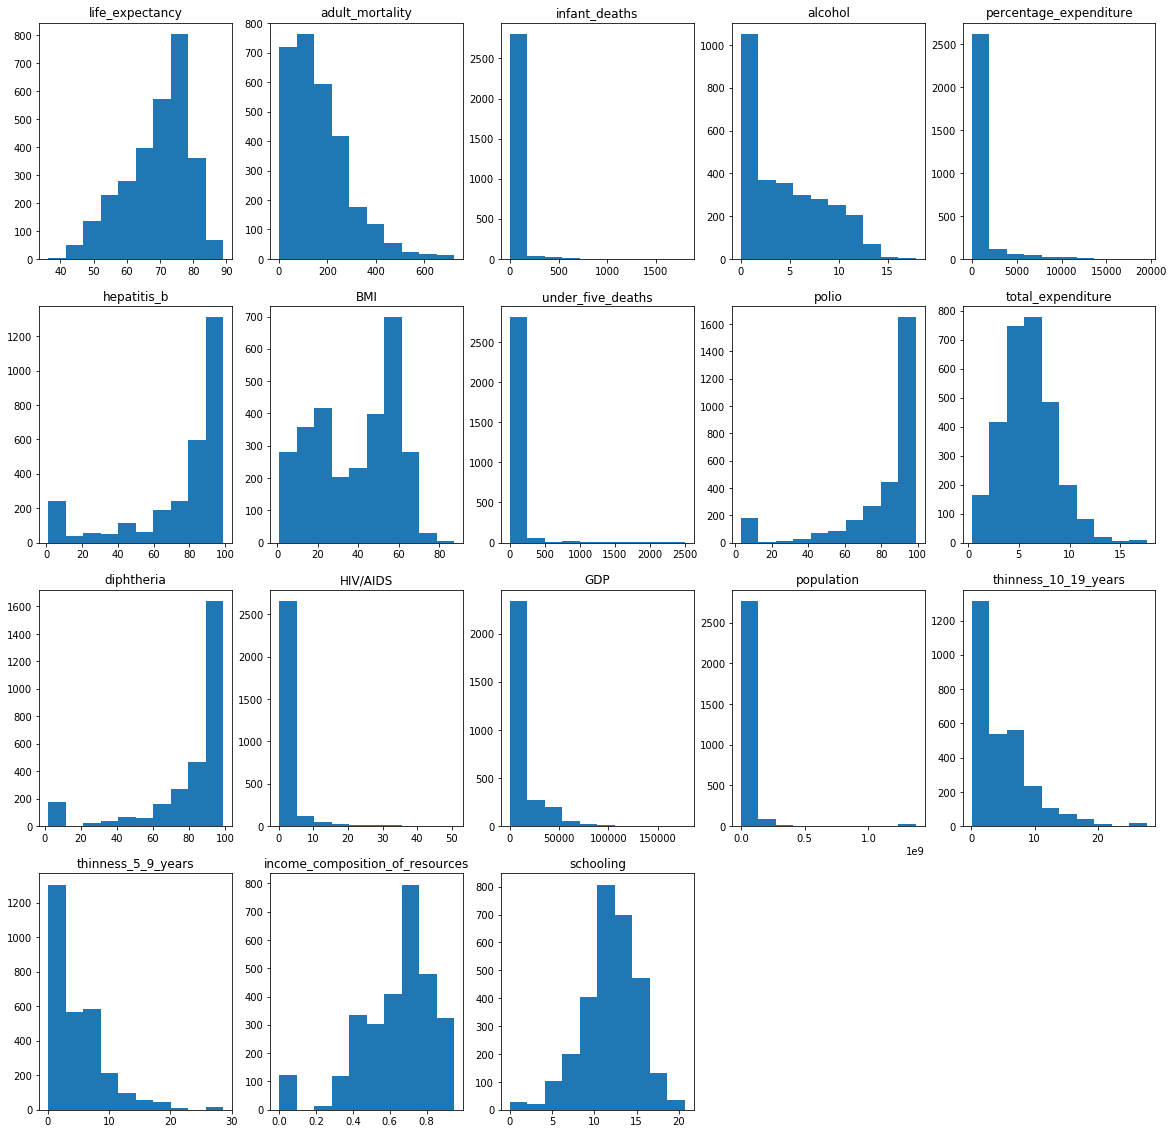

In [0]:
plt.figure(figsize=(20,20))

for i, col in enumerate(lifeexpectancy_df.columns[3:]):
  plt.subplot(4,5,i+1)
  plt.hist(lifeexpectancy_df[col])
  plt.title(col)

plt.show()

In [0]:
lifeexpectancy_df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling
count,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2.899000e+03,2899.000000,2899.000000,2899.000000,2899.000000
mean,2007.504312,69.211349,165.200759,30.646085,4.545961,748.182927,76.428424,38.362918,42.516385,82.117627,5.933843,81.968265,1.763677,10811.044697,3.675417e+07,4.830907,4.861642,0.631286,12.017368
std,4.609555,9.561480,124.554991,118.678671,4.073437,1999.388379,28.075541,19.936987,161.465739,23.735843,2.514397,24.028373,5.108388,16947.617783,1.354270e+08,4.418870,4.508026,0.204221,3.276253
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,22.994490,1.081900e+04,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.000000,74.000000,0.000000,0.635000,5.886643,68.000000,19.400000,0.000000,77.000000,4.260000,78.000000,0.100000,1014.572287,2.272307e+06,1.600000,1.500000,0.504500,10.200000
50%,2008.000000,72.100000,144.000000,3.000000,3.695000,68.707304,89.000000,43.500000,4.000000,93.000000,5.720000,93.000000,0.100000,3567.836438,8.171950e+06,3.300000,3.300000,0.677000,12.350000
75%,2012.000000,75.700000,228.000000,22.500000,7.675000,455.061775,96.000000,56.100000,29.000000,97.000000,7.475000,97.000000,0.800000,12277.565960,2.494389e+07,7.200000,7.200000,0.774000,14.200000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,177593.351900,1.371220e+09,27.700000,28.600000,0.948000,20.700000


There are several categories where the minimum value is 0. For none of these categories is 0 a reasonable minimum. We'll replace all 0 values with medians instead. Since I know the lowest ever recorded BMI was 7.5, I'll do the same with BMI scores below this. Additionally, infant deaths and under five deaths are given per 1000 population. Anything over 1000 is nonsense. 

In [0]:
for col in lifeexpectancy_df.columns[3:]:
  if lifeexpectancy_df[col].min() == 0:
    lifeexpectancy_df.loc[lifeexpectancy_df[col] == 0, col] = lifeexpectancy_df[col].median()
  if col == 'BMI':
    lifeexpectancy_df.loc[lifeexpectancy_df[col] < 7.5, col] = lifeexpectancy_df[col].median()
  if col == 'under_five_deaths' or col == 'infant_deaths':
    lifeexpectancy_df.loc[lifeexpectancy_df[col] > 1000, col] = lifeexpectancy_df[col].median()

In [0]:
# Perform a Box-Cox transform on all variables to normalize them
lifeexpectancy2_df = lifeexpectancy_df.copy()
lambdas = []
print('Lambbas were as follows:')
for col in lifeexpectancy2_df.columns[3:]:
  try:
    boxcox(lifeexpectancy2_df[col])
  except:
    a = 1 - lifeexpectancy2_df[col].min() # shift vectors with non-positive values so the smallest value is 1
    lifeexpectancy2_df[col], lam = boxcox(lifeexpectancy2_df[col] + a)
  else:
    lifeexpectancy2_df[col], lam = boxcox(lifeexpectancy2_df[col])
  lambdas.append(lam)
  print('{}: {}'.format(col, round(lam,4)))

Lambbas were as follows:
life_expectancy: 2.8421
adult_mortality: 0.4223
infant_deaths: -0.2815
alcohol: 0.3573
percentage_expenditure: -0.0196
hepatitis_b: 1.9671
BMI: 1.0822
under_five_deaths: -0.2146
polio: 2.651
total_expenditure: 0.5912
diphtheria: 2.666
HIV/AIDS: -0.6457
GDP: -0.0044
population: 0.0449
thinness_10_19_years: 0.2008
thinness_5_9_years: 0.2176
income_composition_of_resources: 1.6203
schooling: 1.3415


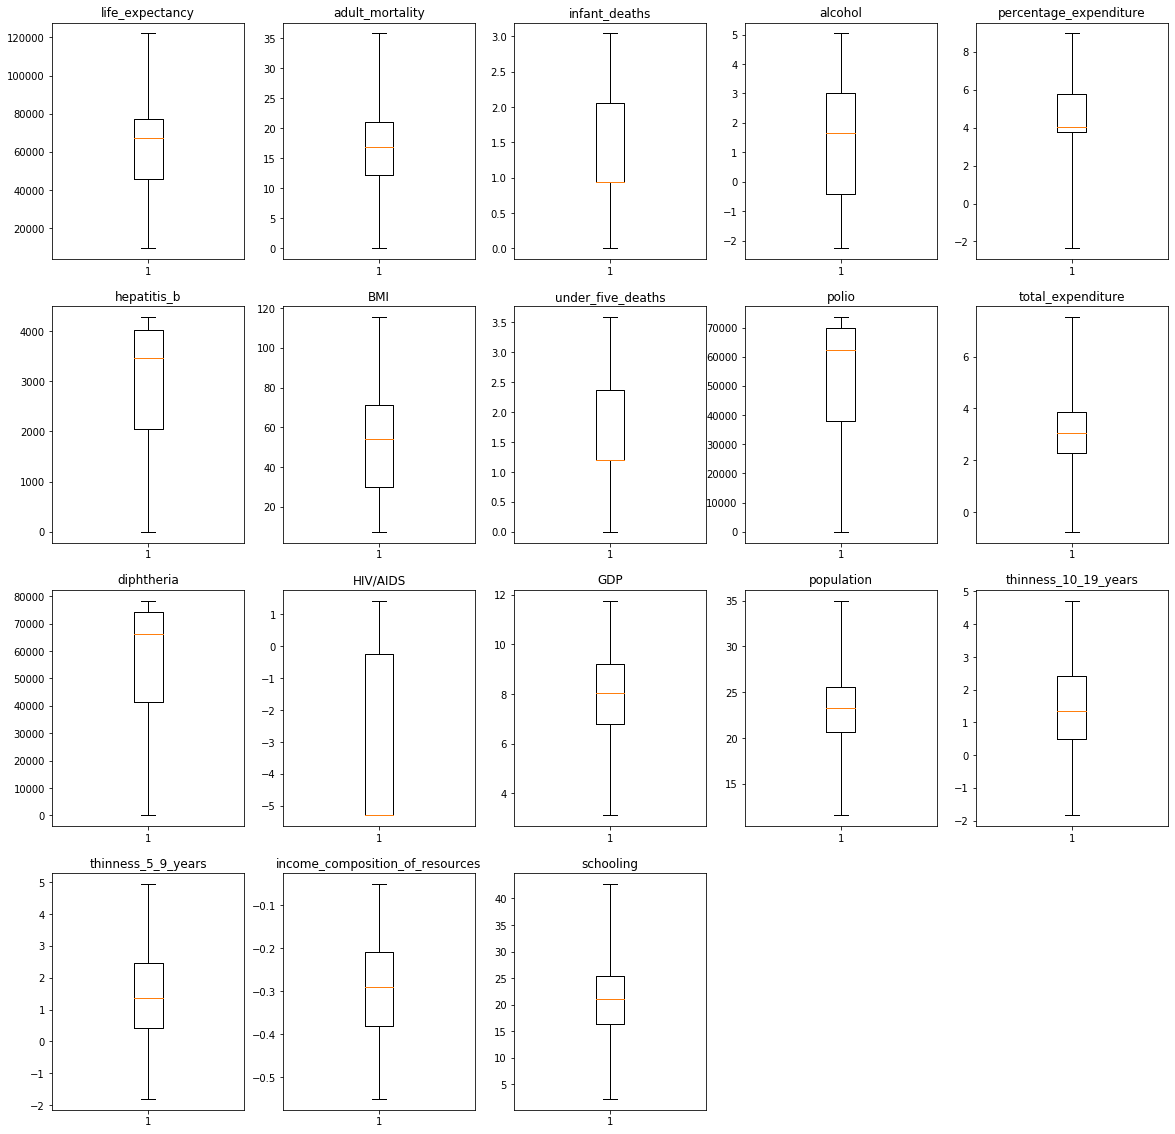

In [0]:
plt.figure(figsize=(20,20))

for i, col in enumerate(lifeexpectancy2_df.columns[3:]):
  plt.subplot(4,5,i+1)
  plt.boxplot(lifeexpectancy2_df[col], whis=5)
  plt.title(col)

plt.show()

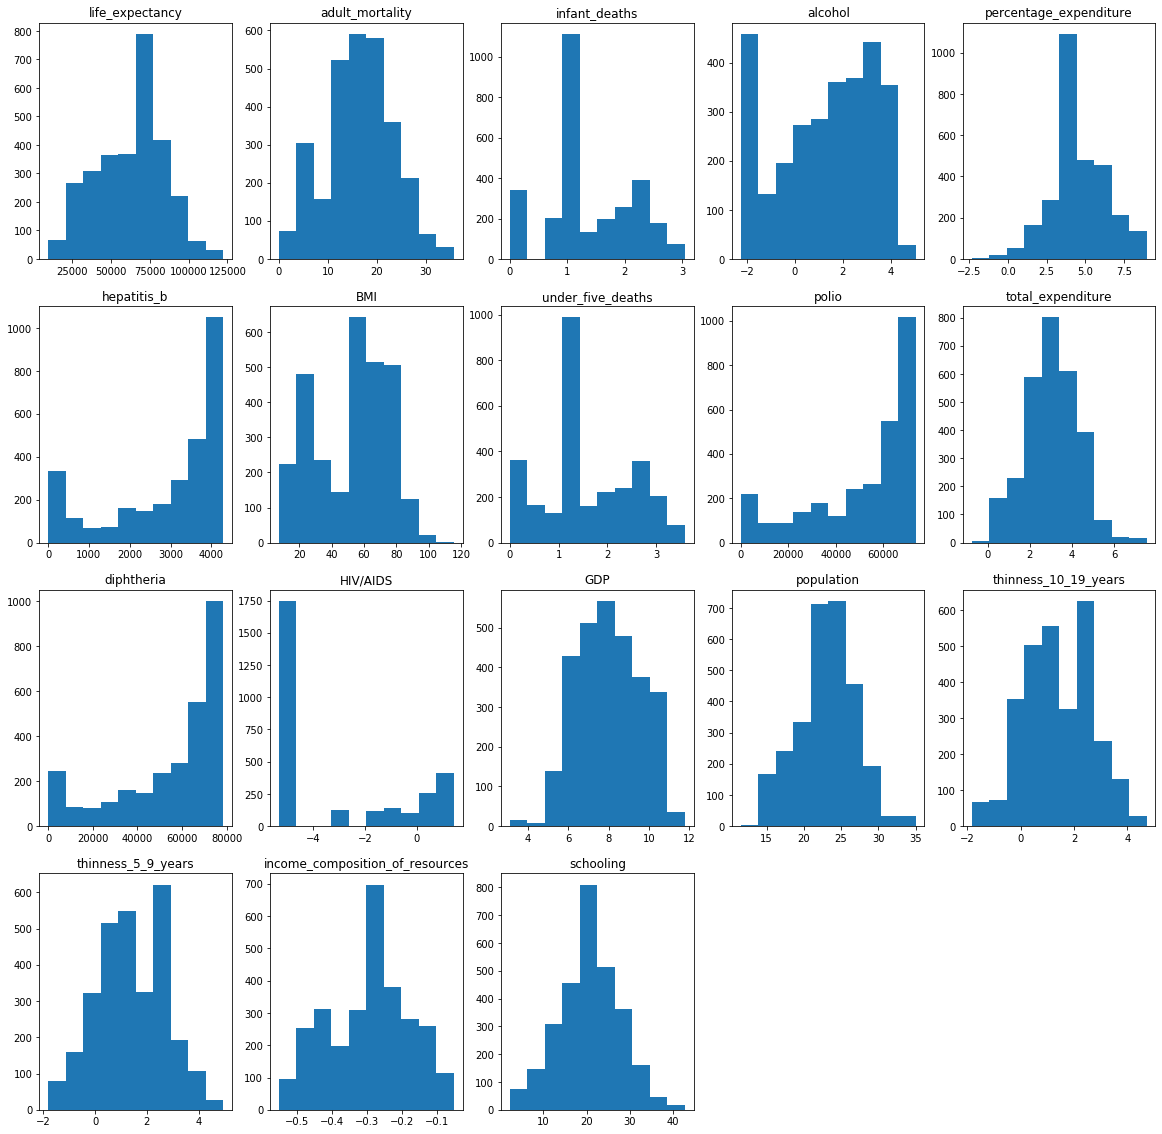

In [0]:
plt.figure(figsize=(20,20))

for i, col in enumerate(lifeexpectancy2_df.columns[3:]):
  plt.subplot(4,5,i+1)
  plt.hist(lifeexpectancy2_df[col])
  plt.title(col)

plt.show()

Continous variables are looking closer to approximating normal than they had been before Box-Cox transformation. Now we can take a look at some multivariate exploration, starting with our categorical variable, status.

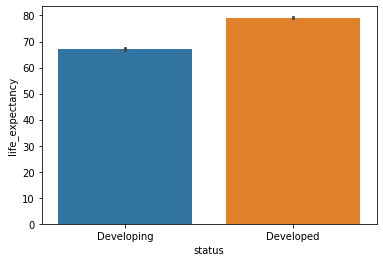

In [0]:
# create dummy variable for status
lifeexpectancy2_df['developing'] = pd.get_dummies(lifeexpectancy2_df['status'], drop_first=True)
sns.barplot(lifeexpectancy_df['status'], lifeexpectancy_df['life_expectancy'])

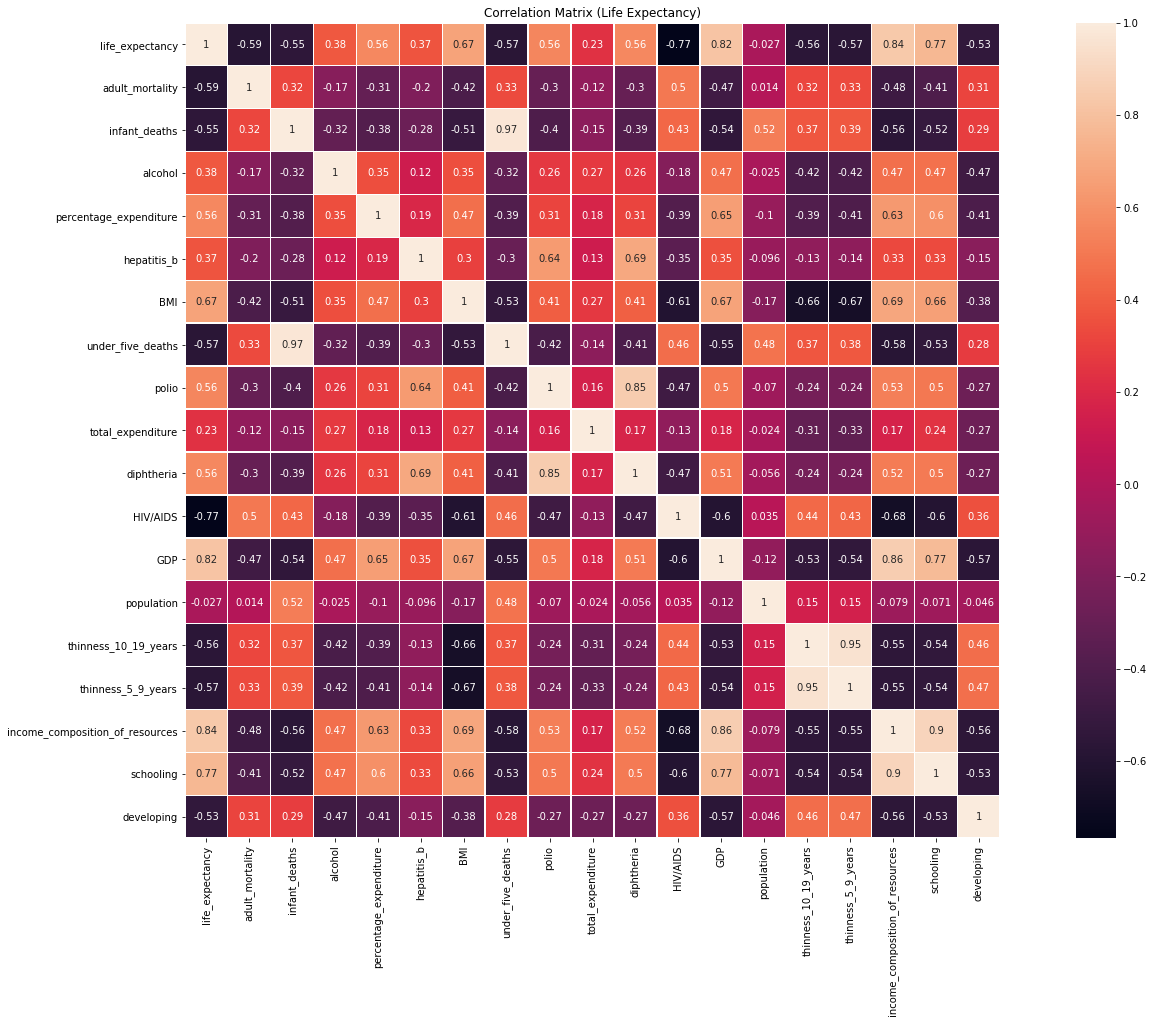

In [0]:
# make the correlation matrices.
corrmat = lifeexpectancy2_df.iloc[:,3:].corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(27,15))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Life Expectancy)")

plt.show()

Based on our color map, we will take the following actions towards reducing dimensionality from its current level of 18:

1. Eliminate 'population' variable, as it has little correlation (-0.027) to the target.
2. Eliminate 'infant_deaths' variable, since it's highly correlated (0.97) to another variable, 'under_five_deaths'.
3. Eliminate 'thinness_10_19_years' variable, since it's highly correlated (0.95) to another variable, 'thinness_5_9_years'.
4. Eliminate 'income_composition_of_resources' variable, since it's highly correlated (0.90) to another variable, 'schooling'.
5. Run PCA on 'adult_mortality', 'under_five_deaths', 'HIV/AIDS', 'thinness_5_9_years', and 'developing' as a group called 'dev_signs'.
6. Run PCA on 'hepatitis_b', 'diphtheria', 'polio', 'BMI', and 'alcohol' as a group called 'health'.
7. Run PCA on 'percentage_expenditure', 'total_expenditure', 'GDP', and 'schooling' as a group called 'wealth'.

In [0]:
dev_signs = ['adult_mortality', 'under_five_deaths', 'HIV/AIDS', 'thinness_5_9_years', 'developing']
health = ['hepatitis_b', 'diphtheria', 'polio', 'BMI', 'alcohol']
wealth = ['percentage_expenditure', 'total_expenditure', 'GDP', 'schooling']
lifeexpectancy3_df = lifeexpectancy2_df['life_expectancy'].reset_index().drop(columns='index')

The percentage of total variance in the dataset explained by the components from Sklearn PCA.
 [0.51025317 0.1589889  0.13609854 0.10289359 0.0917658 ]


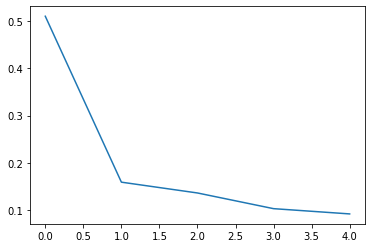

In [0]:
cols = dev_signs
X = StandardScaler().fit_transform(lifeexpectancy2_df[cols])

sklearn_pca = PCA(n_components=len(cols))
Y_sklearn1 = pd.DataFrame(data=sklearn_pca.fit_transform(X), columns=['dev_signs_1', 'dev_signs_2', 'dev_signs_3', 'dev_signs_4', 'dev_signs_5'])


print('The percentage of total variance in the dataset explained by the',
      'components from Sklearn PCA.\n',
      sklearn_pca.explained_variance_ratio_)

plt.plot(range(0,len(cols)), sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by the components from Sklearn PCA.
 [0.5661766  0.20564934 0.1236504  0.07576943 0.02875424]


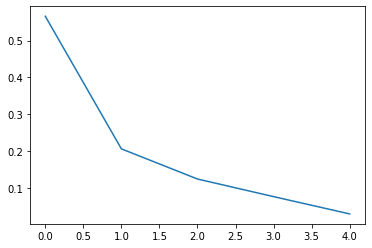

In [0]:
cols = health
X = StandardScaler().fit_transform(lifeexpectancy2_df[cols])

sklearn_pca = PCA(n_components=len(cols))
Y_sklearn2 = pd.DataFrame(data=sklearn_pca.fit_transform(X), columns=['health_1', 'health_2', 'health_3', 'health_4', 'health_5'])

print('The percentage of total variance in the dataset explained by the',
      'components from Sklearn PCA.\n',
      sklearn_pca.explained_variance_ratio_)

plt.plot(range(0,len(cols)), sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by the components from Sklearn PCA.
 [0.60775953 0.23038818 0.10735932 0.05449297]


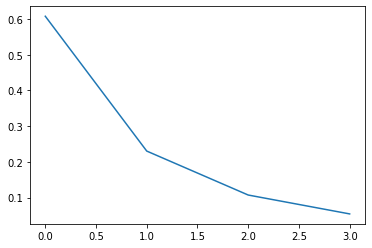

In [0]:
cols = wealth
X = StandardScaler().fit_transform(lifeexpectancy2_df[cols])

sklearn_pca = PCA(n_components=len(cols))
Y_sklearn3 = pd.DataFrame(data=sklearn_pca.fit_transform(X), columns=['wealth_1', 'wealth_2', 'wealth_3', 'wealth_4'])

print('The percentage of total variance in the dataset explained by the',
      'components from Sklearn PCA.\n',
      sklearn_pca.explained_variance_ratio_)

plt.plot(range(0,len(cols)), sklearn_pca.explained_variance_ratio_)

In [0]:
lifeexpectancy3_df = pd.concat([lifeexpectancy3_df, Y_sklearn1, Y_sklearn2, Y_sklearn3], axis=1)

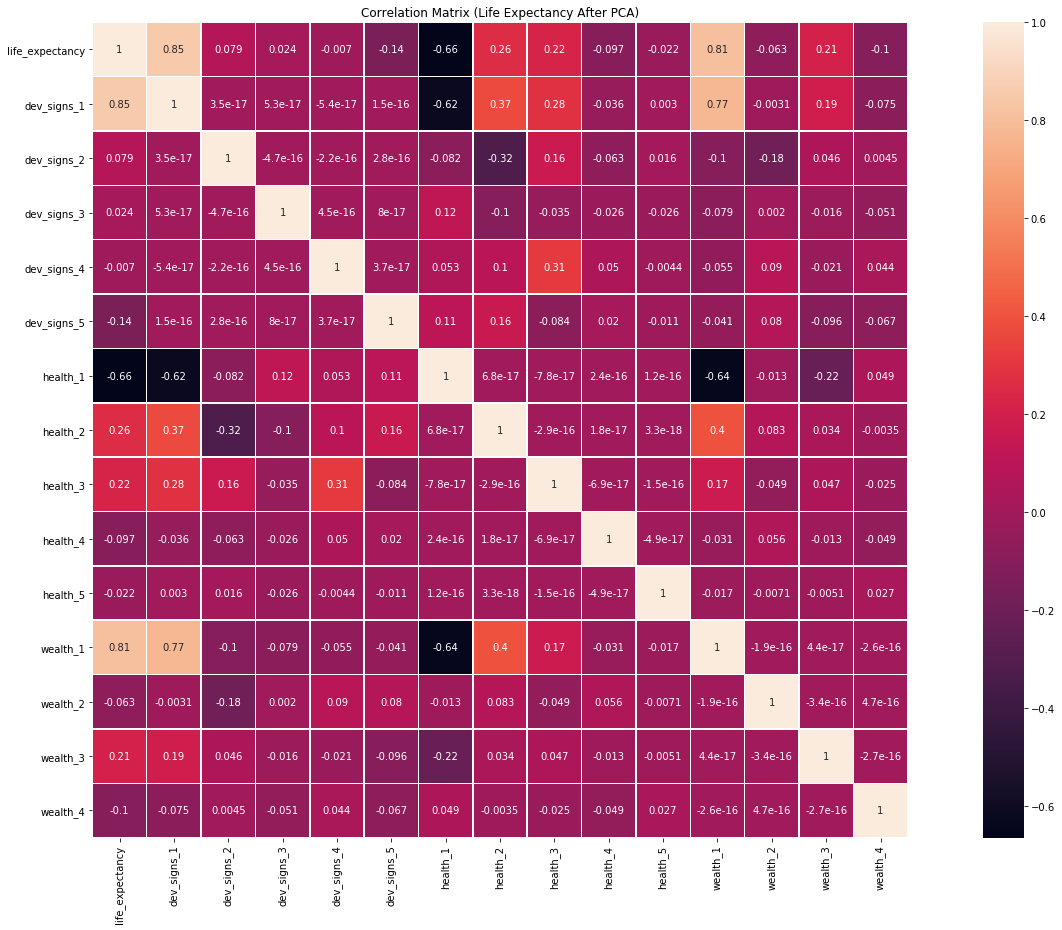

In [0]:
# make the correlation matrices.
corrmat = lifeexpectancy3_df.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(27,15))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Life Expectancy After PCA)")

plt.show()

Based on the color map, as well as the explained variance ratios, we choose to take only the first component from each round of PCA. Dimensionality has been reduced to 3 features, namely dev_signs_1, health_1, and wealth_1.